<a href="https://colab.research.google.com/github/kridtapon/WFO-KST-RVI-Momentum-Strategy/blob/main/WFO_KST_RVI_Momentum_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-8-1f0a98309a33>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-1f0a98309a33>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-1f0a98309a33>:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year         Best_Params  Test_Return
0  2020  (12, 14, 7, 9, 20)     0.086933
1  2021  (6, 18, 9, 11, 18)    -0.131215
2  2022  (10, 18, 9, 9, 10)    -0.139445
3  2023  (10, 18, 9, 9, 10)     0.224261
4  2024  (10, 18, 9, 9, 10)     0.914975
5  2025  (4, 26, 3, 15, 12)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           198154.862226
Total Return [%]                        98.154862
Benchmark Return [%]                     8.201472
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6657.400554
Max Drawdown [%]                        56.140784
Max Drawdown Duration                      1106.0
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades          

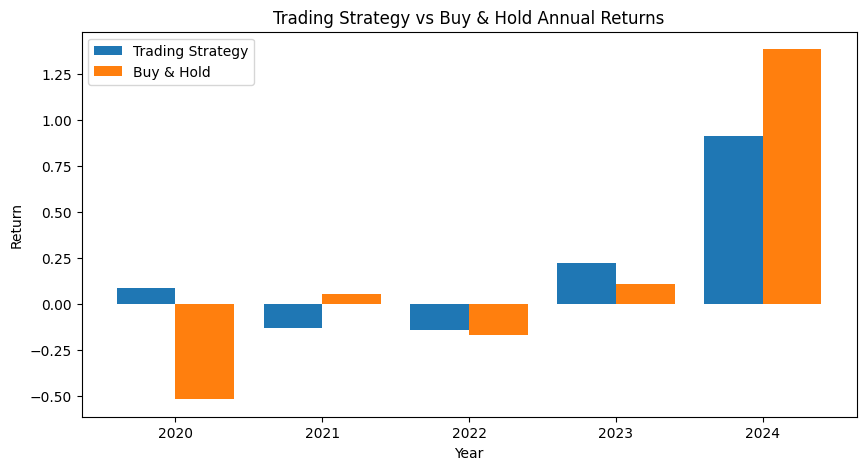

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate KST for a specific time period
def calculate_kst_indicator(df, kst_params):
    kst, kst_signal = calculate_kst(df, *kst_params)
    df['KST'] = kst
    df['KST_Signal'] = kst_signal
    return df

# Function to calculate Relative Vigor Index (RVI)
def calculate_rvi(df, period=14):
    """
    Calculate Relative Vigor Index (RVI).
    """
    close_open = df['Close'] - df['Open']
    high_low = df['High'] - df['Low']

    rvi = close_open.rolling(window=period).sum() / high_low.rolling(window=period).sum()

    return rvi

# Walk-forward optimization with KST and RVI
def walk_forward_optimization_kst_rvi(df, start_year, end_year):
    results = []

    # Define dynamic ranges for KST and RVI periods
    kst_short_period_range = range(4, 21, 2)  # Range for KST short period
    kst_long_period_range = range(14, 31, 2)  # Range for KST long period
    roc_short_period_range = range(3, 11, 2)  # Range for KST ROC short period
    roc_long_period_range = range(5, 16, 2)   # Range for KST ROC long period
    rvi_period_range = range(10, 21, 2)       # Range for RVI period

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of KST and RVI parameters
        for params in itertools.product(kst_short_period_range, kst_long_period_range,
                                        roc_short_period_range, roc_long_period_range,
                                        rvi_period_range):
            kst_short_period, kst_long_period, roc_short_period, roc_long_period, rvi_period = params

            # Calculate KST and RVI on the training data
            train_data = calculate_kst_indicator(train_data, (kst_short_period, kst_long_period, roc_short_period, roc_long_period))
            train_data['RVI'] = calculate_rvi(train_data, rvi_period)

            # Generate entry and exit signals based on KST and RVI
            entries = (train_data['KST'] > train_data['KST_Signal']) & (train_data['RVI'] > 0)
            exits = (train_data['KST'] < train_data['KST_Signal']) & (train_data['RVI'] < 0)

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (kst_short_period, kst_long_period, roc_short_period, roc_long_period, rvi_period)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply KST and RVI indicators
        yearly_data = calculate_kst_indicator(yearly_data, best_params[:4])
        yearly_data['RVI'] = calculate_rvi(yearly_data, best_params[4])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['KST'] > yearly_data['KST_Signal']) & (yearly_data['RVI'] > 0)
        exits = (yearly_data['KST'] < yearly_data['KST_Signal']) & (yearly_data['RVI'] < 0)

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'UAL'  # RCL! UAL! BTC-USD GC=F NQ=F
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_kst_rvi(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply KST and RVI indicators
    yearly_data = calculate_kst_indicator(yearly_data, params[:4])
    yearly_data['RVI'] = calculate_rvi(yearly_data, params[4])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['KST'] > yearly_data['KST_Signal']) & (yearly_data['RVI'] > 0)
    exits = (yearly_data['KST'] < yearly_data['KST_Signal']) & (yearly_data['RVI'] < 0)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [9]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,108201.471791
Total Return [%],8.201472
Benchmark Return [%],8.201472
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],77.80254


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate KST for a specific time period
def calculate_kst_indicator(df, kst_params):
    kst, kst_signal = calculate_kst(df, *kst_params)
    df['KST'] = kst
    df['KST_Signal'] = kst_signal
    return df

# Function to calculate Relative Vigor Index (RVI)
def calculate_rvi(df, period=14):
    """
    Calculate Relative Vigor Index (RVI).
    """
    close_open = df['Close'] - df['Open']
    high_low = df['High'] - df['Low']

    rvi = close_open.rolling(window=period).sum() / high_low.rolling(window=period).sum()

    return rvi

# Define the stock symbol and time period
symbol = 'BTC-USD'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-03-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameters for KST calculation
kst_params = (14, 14, 3, 13)

# Calculate KST and Signal line
df = calculate_kst_indicator(df, kst_params)

# Calculate Relative Vigor Index (RVI)
df['RVI'] = calculate_rvi(df,period=14)

# Define Entry and Exit signals based on KST and RVI
df['Entry'] = (df['KST'] > df['KST_Signal']) & (df['RVI'] > 0)
df['Exit'] = (df['KST'] < df['KST_Signal']) & (df['RVI'] < 0)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2024) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2024-01-01 00:00:00
End                           2025-02-07 00:00:00
Period                                        403
Start Value                              100000.0
End Value                           175313.014265
Total Return [%]                        75.313014
Benchmark Return [%]                   120.845405
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3599.402909
Max Drawdown [%]                         15.12773
Max Drawdown Duration                       105.0
Total Trades                                   12
Total Closed Trades                            12
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            41.666667
Best Trade [%]                          56.157271
Worst Trade [%]                          -8.09169
Avg Winning Trade [%]                   19.970776
Avg Losing Trade [%]                    -3.909334
